In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

def load_data(file_path, sheet_name="IRCTC Stock Price"):
    return pd.read_excel(file_path, sheet_name=sheet_name)

def preprocess_data(df):
    df['Chg%'] = pd.to_numeric(df['Chg%'], errors='coerce')

    def convert_volume(value):
        """Convert M (million) and K (thousand) values into numerical format."""
        if isinstance(value, str):
            if 'M' in value:
                return float(value.replace('M', '')) * 1e6
            elif 'K' in value:
                return float(value.replace('K', '')) * 1e3
        return value

    df['Volume'] = df['Volume'].apply(convert_volume)
    df = df.dropna()

    # Define target variable: 1 if price increases the next day, else 0
    df['Next_Day_Price'] = df['Price'].shift(-1)
    df['Target'] = (df['Next_Day_Price'] > df['Price']).astype(int)
    df = df.dropna()  # Remove last row without target

    # Select features, excluding 'Price' to prevent data leakage
    X = df[['Open', 'High', 'Low', 'Volume']]
    y = df['Target']

    return X, y

def split_and_standardize(X, y, test_size=0.2, random_state=42):
    """
    Splits data into training and test sets, then standardizes the features.

    Parameters:
    X (pd.DataFrame): Feature set.
    y (pd.Series): Target variable.
    test_size (float): Proportion of test data.
    random_state (int): Seed for reproducibility.

    Returns:
    np.array: Standardized training and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train):

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the model and returns confusion matrices & classification reports.

    Parameters:
    model: Trained RandomForest model.
    X_train, X_test (np.array): Standardized training and test features.
    y_train, y_test (pd.Series): Training and test labels.

    Returns:
    dict: Confusion matrices and classification reports.
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results = {
        "train_confusion_matrix": confusion_matrix(y_train, y_train_pred),
        "test_confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "train_classification_report": classification_report(y_train, y_train_pred, output_dict=True),
        "test_classification_report": classification_report(y_test, y_test_pred, output_dict=True),
    }

    return results

# ---------------- Main Execution ---------------- #

# Load dataset
file_path = "Lab Session Data.xlsx"  # Update path if needed
df = load_data(file_path)

# Preprocess data
X, y = preprocess_data(df)

# Split and standardize
X_train, X_test, y_train, y_test = split_and_standardize(X, y)

# Train model
model = train_model(X_train, y_train)

# Evaluate model
results = evaluate_model(model, X_train, y_train, X_test, y_test)

# Display results properly in Colab/Jupyter
print("\nConfusion Matrix - Training Data:")
print(results["train_confusion_matrix"])
print("\nClassification Report - Training Data:")
print(pd.DataFrame(results["train_classification_report"]).T)

print("\nConfusion Matrix - Test Data:")
print(results["test_confusion_matrix"])
print("\nClassification Report - Test Data:")
print(pd.DataFrame(results["test_classification_report"]).T)



Confusion Matrix - Training Data:
[[ 97   0]
 [  0 101]]

Classification Report - Training Data:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     97.0
1                   1.0     1.0       1.0    101.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    198.0
weighted avg        1.0     1.0       1.0    198.0

Confusion Matrix - Test Data:
[[16 10]
 [10 14]]

Classification Report - Test Data:
              precision    recall  f1-score  support
0              0.615385  0.615385  0.615385     26.0
1              0.583333  0.583333  0.583333     24.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.599359  0.599359  0.599359     50.0
weighted avg   0.600000  0.600000  0.600000     50.0


A2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def load_data(file_path, sheet_name="IRCTC Stock Price"):
    """
    Load stock price data from the given Excel sheet.

    Parameters:
    file_path (str): Path to the Excel file.
    sheet_name (str): Name of the sheet to be read.

    Returns:
    pd.DataFrame: The loaded dataset.
    """
    return pd.read_excel(file_path, sheet_name=sheet_name)

def preprocess_price_data(df):
    """
    Preprocesses stock price data for regression.
    - Converts 'Chg%' to numeric.
    - Converts 'Volume' from M/K format to numerical values.
    - Drops missing values.

    Parameters:
    df (pd.DataFrame): The raw dataset.

    Returns:
    pd.DataFrame, pd.Series: Processed feature set and target variable.
    """
    df['Chg%'] = pd.to_numeric(df['Chg%'], errors='coerce')

    def convert_volume(value):
        """Convert M (million) and K (thousand) values into numerical format."""
        if isinstance(value, str):
            if 'M' in value:
                return float(value.replace('M', '')) * 1e6
            elif 'K' in value:
                return float(value.replace('K', '')) * 1e3
        return value

    df['Volume'] = df['Volume'].apply(convert_volume)
    df = df.dropna()

    # Select features (including Volume)
    X = df[['Open', 'High', 'Low', 'Volume']]
    y = df['Price']  # Target variable

    return X, y

def split_and_standardize(X, y, test_size=0.2, random_state=42):
    """
    Splits data into training and test sets, then standardizes the features.

    Parameters:
    X (pd.DataFrame): Feature set.
    y (pd.Series): Target variable.
    test_size (float): Proportion of test data.
    random_state (int): Seed for reproducibility.

    Returns:
    np.array: Standardized training and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def train_linear_regression(X_train, y_train):
    """
    Trains a Linear Regression model on the given dataset.

    Parameters:
    X_train (np.array): Standardized training features.
    y_train (pd.Series): Training labels.

    Returns:
    model: Trained LinearRegression model.
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_regression_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluates the regression model and calculates MSE, RMSE, MAPE, and R2 scores.

    Parameters:
    model: Trained regression model.
    X_train, X_test: Standardized train-test feature sets.
    y_train, y_test: Train-test labels.

    Returns:
    dict: Evaluation metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute error metrics
    results = {
        "train_mse": mean_squared_error(y_train, y_train_pred),
        "test_mse": mean_squared_error(y_test, y_test_pred),
        "train_rmse": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "test_rmse": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "train_mape": mean_absolute_percentage_error(y_train, y_train_pred),
        "test_mape": mean_absolute_percentage_error(y_test, y_test_pred),
        "train_r2": r2_score(y_train, y_train_pred),
        "test_r2": r2_score(y_test, y_test_pred)
    }

    return results

# ---------------- Main Execution ---------------- #

# Load dataset
file_path = "Lab Session Data.xlsx"  # Update path if needed
df = load_data(file_path)

# Preprocess data
X, y = preprocess_price_data(df)

# Split and standardize
X_train, X_test, y_train, y_test = split_and_standardize(X, y)

# Train regression model for price prediction
reg_model = train_linear_regression(X_train, y_train)

# Evaluate regression model
regression_results = evaluate_regression_model(reg_model, X_train, X_test, y_train, y_test)

# Convert results to DataFrame and print
regression_results_df = pd.DataFrame([regression_results])

# Display results
print("\nRegression Analysis Results:")
print(regression_results_df)



Regression Analysis Results:
   train_mse    test_mse  train_rmse  test_rmse  train_mape  test_mape  \
0  93.188701  180.718044    9.653429  13.443141    0.004458    0.00519   

   train_r2   test_r2  
0  0.998343  0.997306  


A3

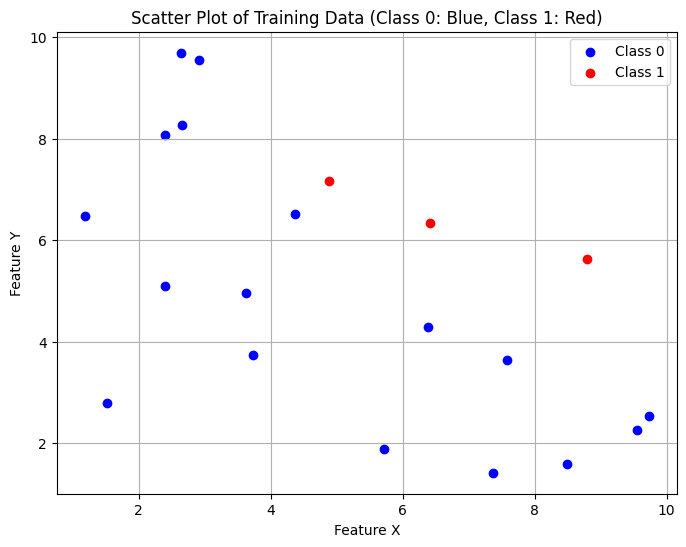

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_points=20, x_range=(1, 10), y_range=(1, 10)):
    """
    Generates random data points for X and Y within the specified range.

    Parameters:
    num_points (int): Number of data points to generate.
    x_range (tuple): Range for X values (min, max).
    y_range (tuple): Range for Y values (min, max).

    Returns:
    np.array: X values.
    np.array: Y values.
    """
    np.random.seed(42)  # Ensures reproducibility
    X = np.random.uniform(x_range[0], x_range[1], num_points)
    Y = np.random.uniform(y_range[0], y_range[1], num_points)
    return X, Y

def assign_classes(X, Y, threshold=30):
    """
    Assigns classes based on the product of X and Y.

    Parameters:
    X (np.array): Feature X values.
    Y (np.array): Feature Y values.
    threshold (float): Threshold value for classification.

    Returns:
    np.array: Array of class labels (0 or 1).
    """
    return np.where(X * Y < threshold, 0, 1)

def plot_data(X, Y, classes):
    """
    Plots the scatter plot of the generated data, coloring the points based on their class.

    Parameters:
    X (np.array): Feature X values.
    Y (np.array): Feature Y values.
    classes (np.array): Class labels for each point.
    """
    plt.figure(figsize=(8, 6))

    for i in range(len(X)):
        color = 'blue' if classes[i] == 0 else 'red'
        plt.scatter(X[i], Y[i], color=color, label=f'Class {classes[i]}' if i in (0, np.where(classes == 1)[0][0]) else "")

    plt.xlabel("Feature X")
    plt.ylabel("Feature Y")
    plt.title("Scatter Plot of Training Data (Class 0: Blue, Class 1: Red)")
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------- Main Execution ---------------- #

# Generate data points
X, Y = generate_data()

# Assign classes
classes = assign_classes(X, Y)

# Plot the data
plot_data(X, Y, classes)


A4

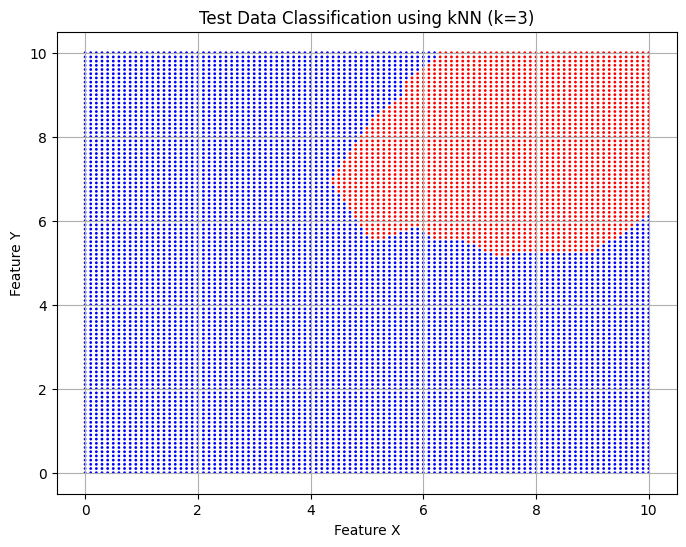

In [5]:
# Re-defining all functions and re-running the entire pipeline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

def generate_training_data(num_points=20, x_range=(1, 10), y_range=(1, 10)):
    """
    Generates random training data points for features X and Y.

    Parameters:
    - num_points (int): Number of training data points to generate.
    - x_range (tuple): Range (min, max) for feature X.
    - y_range (tuple): Range (min, max) for feature Y.

    Returns:
    - np.array: Array of X values.
    - np.array: Array of Y values.
    """
    np.random.seed(42)  # For reproducibility
    X = np.random.uniform(x_range[0], x_range[1], num_points)
    Y = np.random.uniform(y_range[0], y_range[1], num_points)
    return X, Y

def assign_training_classes(X, Y, threshold=30):
    """
    Assigns class labels for training data based on the product of X and Y.

    Parameters:
    - X (np.array): Array of feature X values.
    - Y (np.array): Array of feature Y values.
    - threshold (float): Threshold for class assignment.

    Returns:
    - np.array: Array of class labels (0 or 1).
    """
    return np.where(X * Y < threshold, 0, 1)

def generate_test_data(x_range=(0, 10), y_range=(0, 10), step=0.1):
    """
    Generates a grid of test points covering the feature space.

    Parameters:
    - x_range (tuple): Range (min, max) for feature X.
    - y_range (tuple): Range (min, max) for feature Y.
    - step (float): Increment step for both features.

    Returns:
    - np.array: Meshgrid array for X values.
    - np.array: Meshgrid array for Y values.
    - np.array: Combined test set (each row is a point [x, y]).
    """
    x_values = np.arange(x_range[0], x_range[1] + step, step)
    y_values = np.arange(y_range[0], y_range[1] + step, step)
    X_grid, Y_grid = np.meshgrid(x_values, y_values)
    test_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    return X_grid, Y_grid, test_points

def train_knn_classifier(X_train, Y_train, k=3):
    """
    Trains a kNN classifier using the training data.

    Parameters:
    - X_train (np.array): Array of training feature X values.
    - Y_train (np.array): Array of training feature Y values.
    - k (int): Number of neighbors (default is 3).

    Returns:
    - KNeighborsClassifier: Trained kNN classifier.
    """
    training_features = np.column_stack((X_train, Y_train))
    training_labels = assign_training_classes(X_train, Y_train)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(training_features, training_labels)
    return knn

def classify_test_data(knn_model, test_points):
    """
    Uses the trained kNN classifier to predict class labels for test data.

    Parameters:
    - knn_model (KNeighborsClassifier): The trained kNN classifier.
    - test_points (np.array): The test feature matrix.

    Returns:
    - np.array: Predicted class labels for each test point.
    """
    return knn_model.predict(test_points)

def plot_test_classification_fixed(X_grid, Y_grid, predicted_classes):
    """
    Plots the test set points as a scatter plot, colored by predicted class.

    Parameters:
    - X_grid (np.array): Meshgrid array for X values.
    - Y_grid (np.array): Meshgrid array for Y values.
    - predicted_classes (np.array): Predicted class labels reshaped to grid.
    """
    # Convert predicted classes into a 1D color list
    color_map = np.where(predicted_classes.ravel() == 0, 'blue', 'red')

    plt.figure(figsize=(8, 6))
    plt.scatter(X_grid.ravel(), Y_grid.ravel(), c=color_map, s=1)  # Flattened color array
    plt.xlabel("Feature X")
    plt.ylabel("Feature Y")
    plt.title("Test Data Classification using kNN (k=3)")
    plt.grid(True)
    plt.show()

# ---------------- Main Execution ---------------- #

# Step 1: Generate training data (20 points) and assign classes.
X_train, Y_train = generate_training_data()

# Step 2: Generate test data (grid points) from 0 to 10 with increments of 0.1.
X_grid, Y_grid, test_points = generate_test_data()

# Step 3: Train the kNN classifier (k=3) using the training data.
knn_model = train_knn_classifier(X_train, Y_train, k=3)

# Step 4: Classify the 10,000 test points using the trained kNN classifier.
predicted_test_classes = classify_test_data(knn_model, test_points)
predicted_test_classes = predicted_test_classes.reshape(X_grid.shape)  # Reshape for visualization

# Step 5: Plot the test set classification.
plot_test_classification_fixed(X_grid, Y_grid, predicted_test_classes)


A5

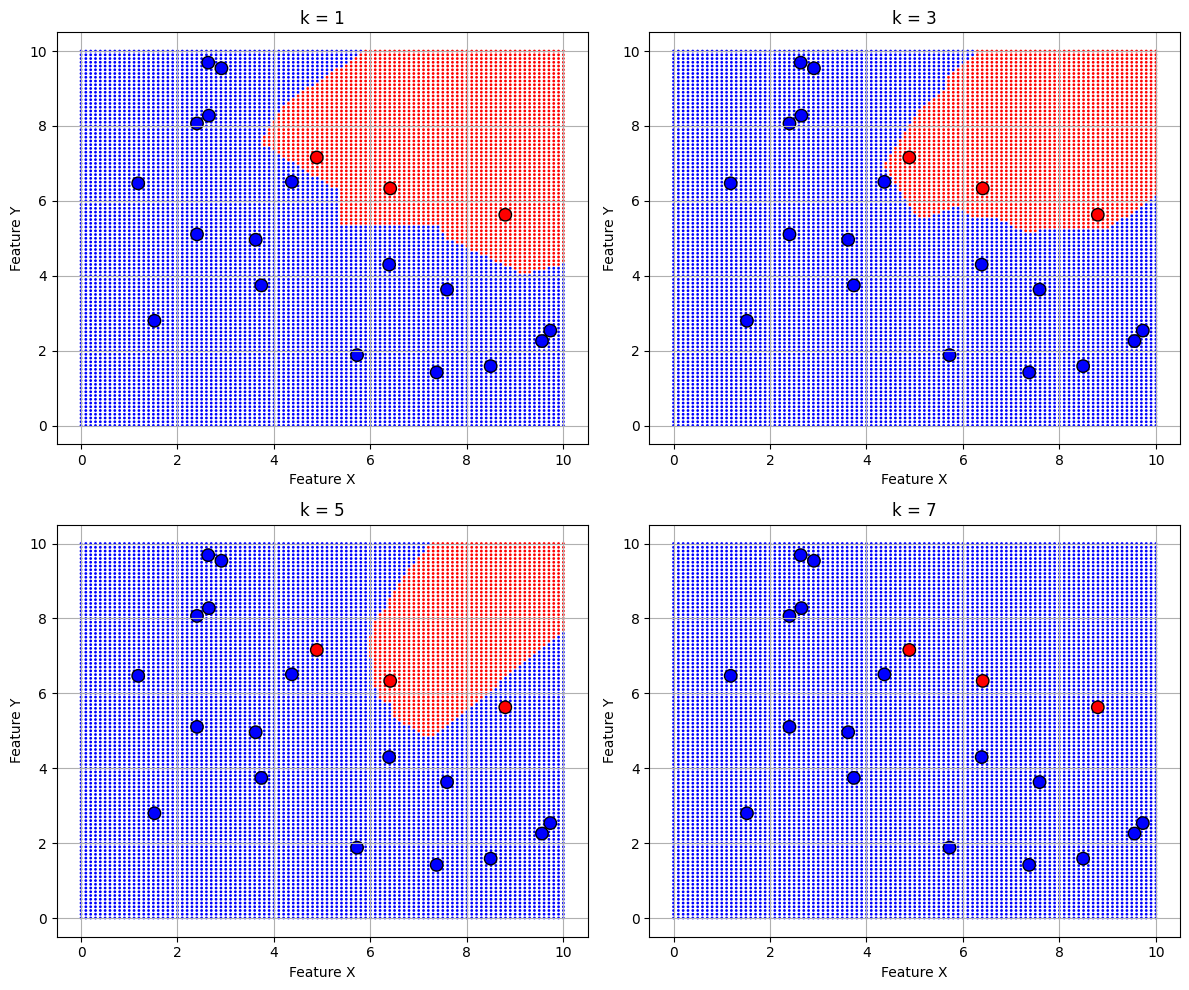

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

def generate_training_data(num_points=20, x_range=(1, 10), y_range=(1, 10)):
    """
    Generates random training data points for features X and Y.
    """
    np.random.seed(42)  # Ensures reproducibility
    X = np.random.uniform(x_range[0], x_range[1], num_points)
    Y = np.random.uniform(y_range[0], y_range[1], num_points)
    return X, Y

def assign_training_classes(X, Y, threshold=30):
    """
    Assigns class labels for training data based on the product of X and Y.
    """
    return np.where(X * Y < threshold, 0, 1)

def generate_test_data(x_range=(0, 10), y_range=(0, 10), step=0.1):
    """
    Generates a grid of test points covering the feature space.
    """
    x_vals = np.arange(x_range[0], x_range[1] + step, step)
    y_vals = np.arange(y_range[0], y_range[1] + step, step)
    X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
    test_points = np.c_[X_grid.ravel(), Y_grid.ravel()]
    return X_grid, Y_grid, test_points

def train_knn_classifier(X_train, Y_train, k=3):
    """
    Trains a kNN classifier using the training data.
    """
    training_features = np.column_stack((X_train, Y_train))
    training_labels = assign_training_classes(X_train, Y_train)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(training_features, training_labels)
    return knn

def classify_test_points(knn_model, test_points):
    """
    Predicts class labels for the test data.
    """
    return knn_model.predict(test_points)

# -------------------------------------------------- #
#                   MAIN PROGRAM                     #
# -------------------------------------------------- #

# 1. Generate and label the training data
X_train, Y_train = generate_training_data()
train_labels = assign_training_classes(X_train, Y_train)

# 2. Generate the test data (0-10 range, step 0.1 -> ~10,000 points)
X_grid, Y_grid, test_points = generate_test_data()

# 3. k values to compare
k_values = [1, 3, 5, 7]

# 4. Create subplots for each k
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten 2D array of axes for easy iteration

for idx, k in enumerate(k_values):
    # 4a. Train kNN model with k
    knn_model = train_knn_classifier(X_train, Y_train, k=k)

    # 4b. Predict classes for test grid
    test_pred = classify_test_points(knn_model, test_points)
    test_pred = test_pred.reshape(X_grid.shape)  # Reshape to match grid

    # 4c. Convert predictions to color map: 0 -> 'blue', 1 -> 'red'
    color_map = np.where(test_pred.ravel() == 0, 'blue', 'red')

    # 4d. Plot on the respective subplot
    ax = axes[idx]
    ax.set_title(f"k = {k}")
    ax.set_xlabel("Feature X")
    ax.set_ylabel("Feature Y")

    # Scatter all test points with tiny dots
    ax.scatter(X_grid.ravel(), Y_grid.ravel(), c=color_map, s=1)

    # Overlay training points
    # Blue if label=0, Red if label=1
    train_colors = np.where(train_labels == 0, 'blue', 'red')
    ax.scatter(X_train, Y_train, c=train_colors, edgecolors='black', s=80, marker='o')

    ax.grid(True)

plt.tight_layout()
plt.show()


A6

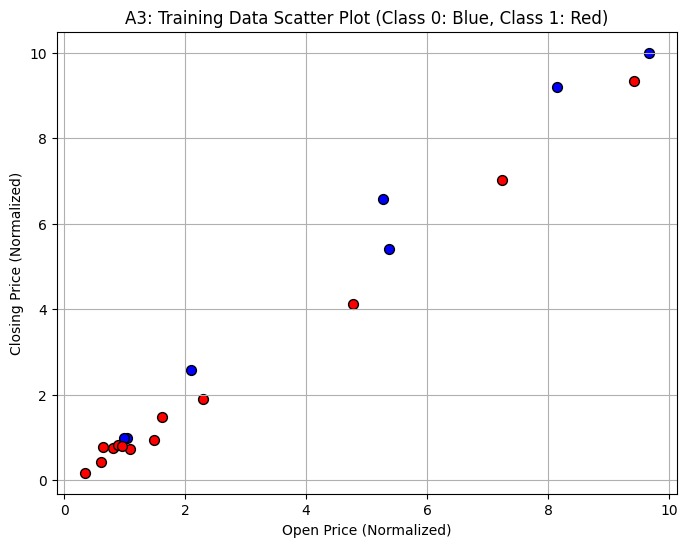

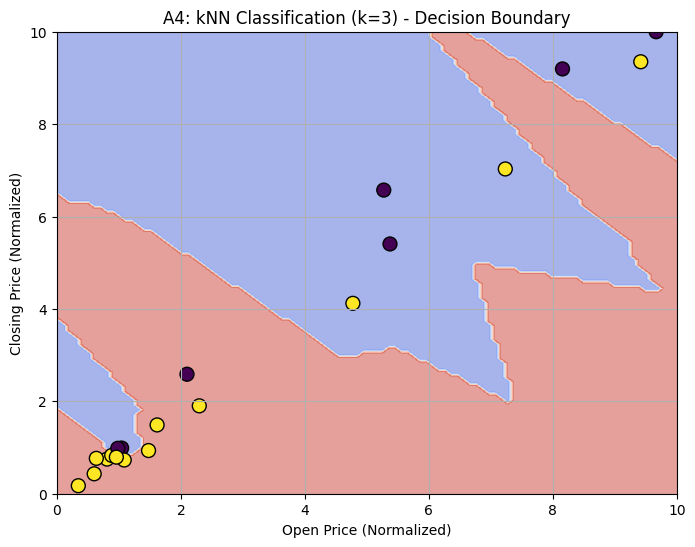

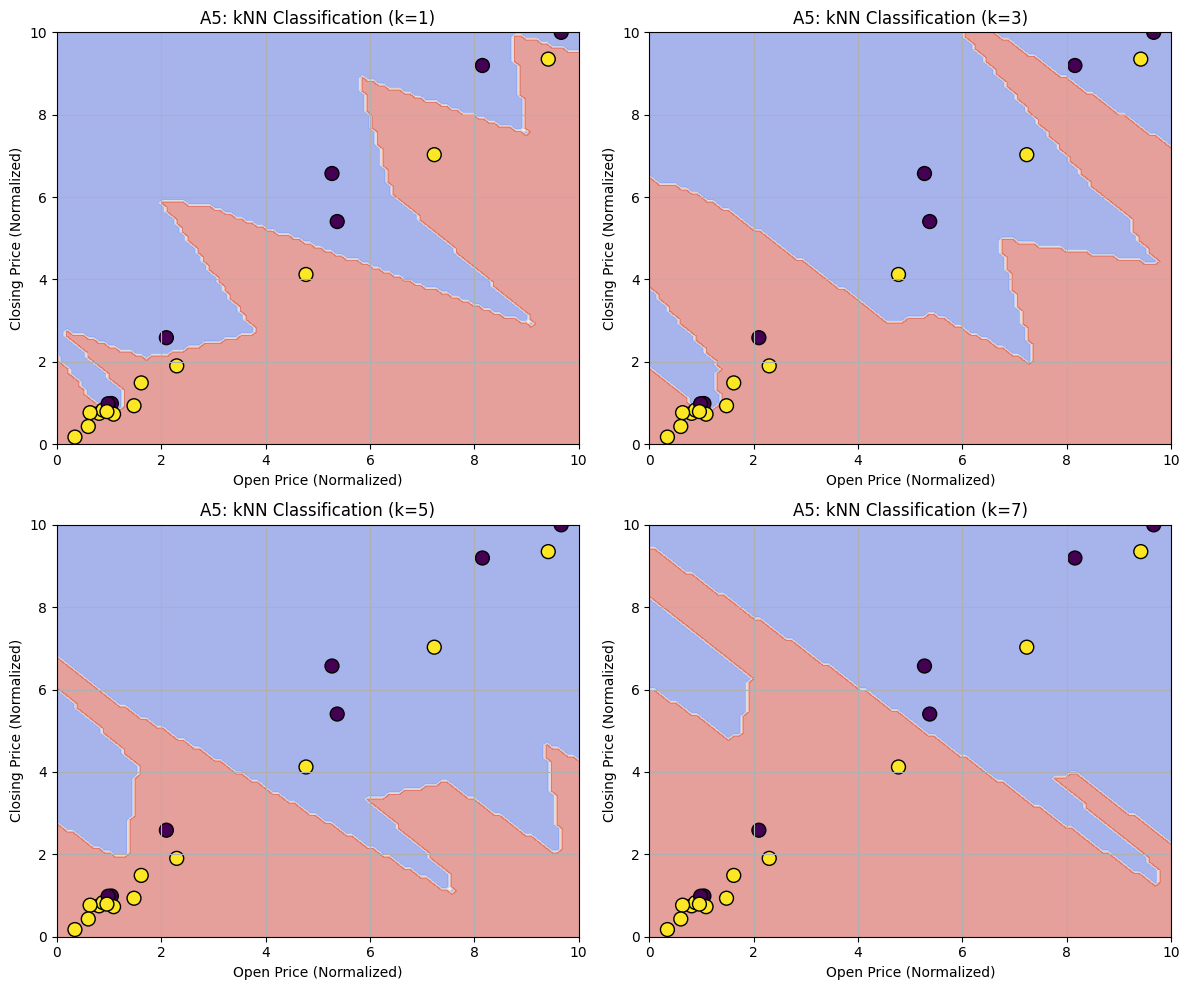

In [8]:
# Full correct code to repeat A3-A5 using project data and ensure correct output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

# Load project dataset
file_path = "Lab Session Data.xlsx"
df = pd.read_excel(file_path, sheet_name="IRCTC Stock Price")

# Select two features for classification (example: 'Open' and 'Price')
df = df[['Open', 'Price']].dropna()

# Normalize features between 0 and 10 for better visualization
scaler = MinMaxScaler(feature_range=(0, 10))
df[['Open', 'Price']] = scaler.fit_transform(df[['Open', 'Price']])

# Define class labels: Class 1 if next day price > current price, else Class 0
df['Class'] = (df['Price'].shift(-1) > df['Price']).astype(int)
df.dropna(inplace=True)  # Drop last row without class label

# Step 1: Select 20 training points randomly
train_data = df.sample(20, random_state=42)
X_train, Y_train = train_data['Open'].values, train_data['Price'].values
train_labels = train_data['Class'].values

# Plot A3: Training Data Scatter Plot
plt.figure(figsize=(8, 6))
for i in range(20):
    color = 'blue' if train_labels[i] == 0 else 'red'
    plt.scatter(X_train[i], Y_train[i], color=color, s=50, edgecolors='black')

plt.xlabel("Open Price (Normalized)")
plt.ylabel("Closing Price (Normalized)")
plt.title("A3: Training Data Scatter Plot (Class 0: Blue, Class 1: Red)")
plt.grid(True)
plt.show()

# Step 2: Generate test set (10,000 grid points from 0-10)
x_vals = np.linspace(0, 10, 100)
y_vals = np.linspace(0, 10, 100)
X_grid, Y_grid = np.meshgrid(x_vals, y_vals)
test_points = np.c_[X_grid.ravel(), Y_grid.ravel()]

# Train kNN classifier (k=3) and classify test data
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(np.column_stack((X_train, Y_train)), train_labels)
test_predictions = knn_model.predict(test_points).reshape(X_grid.shape)

# Plot A4: kNN Classification with k=3
plt.figure(figsize=(8, 6))
plt.contourf(X_grid, Y_grid, test_predictions, alpha=0.5, cmap="coolwarm")
plt.scatter(X_train, Y_train, c=train_labels, edgecolors='black', s=100, marker='o')
plt.xlabel("Open Price (Normalized)")
plt.ylabel("Closing Price (Normalized)")
plt.title("A4: kNN Classification (k=3) - Decision Boundary")
plt.grid(True)
plt.show()

# Step 3: Repeat A4 for different k values
k_values = [1, 3, 5, 7]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, k in enumerate(k_values):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(np.column_stack((X_train, Y_train)), train_labels)

    test_predictions = knn_model.predict(test_points).reshape(X_grid.shape)

    ax = axes[idx]
    ax.contourf(X_grid, Y_grid, test_predictions, alpha=0.5, cmap="coolwarm")
    ax.scatter(X_train, Y_train, c=train_labels, edgecolors='black', s=100, marker='o')
    ax.set_title(f"A5: kNN Classification (k={k})")
    ax.set_xlabel("Open Price (Normalized)")
    ax.set_ylabel("Closing Price (Normalized)")
    ax.grid(True)

plt.tight_layout()
plt.show()


A7

In [13]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# -------------------------- Data Preparation -------------------------- #

# Load project dataset
file_path = "Lab Session Data.xlsx"
df = pd.read_excel(file_path, sheet_name="IRCTC Stock Price")

# Select two features for classification (e.g., 'Open' and 'Price')
df = df[['Open', 'Price']].dropna()

# Normalize the features to a scale between 0 and 10 for visualization
scaler = MinMaxScaler(feature_range=(0, 10))
df[['Open', 'Price']] = scaler.fit_transform(df[['Open', 'Price']])

# Define class labels: Class 1 if next day's price > current day's price, else Class 0
df['Class'] = (df['Price'].shift(-1) > df['Price']).astype(int)
df.dropna(inplace=True)  # Remove the last row which doesn't have a class label

# Randomly sample 20 training points
train_data = df.sample(20, random_state=42)
X_train = train_data[['Open', 'Price']].values  # Training features
y_train = train_data['Class'].values            # Training labels

# ---------------------- Hyperparameter Tuning ------------------------- #

# Create a pipeline for kNN classification
pipeline = Pipeline([
    ('knn', KNeighborsClassifier())
])

# Define the hyperparameter search space: k values from 1 to max available samples
param_grid = {'knn__n_neighbors': np.arange(1, min(15, len(X_train)))}

# Use GridSearchCV for hyperparameter tuning with 3-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, error_score=0)
grid_search.fit(X_train, y_train)
best_k_grid = grid_search.best_params_['knn__n_neighbors']

# Use RandomizedSearchCV for hyperparameter tuning (10 iterations)
random_search = RandomizedSearchCV(pipeline, param_grid, cv=3, scoring='accuracy',
                                   n_iter=10, n_jobs=-1, random_state=42, error_score=0)
random_search.fit(X_train, y_train)
best_k_random = random_search.best_params_['knn__n_neighbors']

# Store and display the results
best_k_results = pd.DataFrame({
    "Method": ["GridSearchCV", "RandomizedSearchCV"],
    "Best k": [best_k_grid, best_k_random]
})

print(best_k_results)


               Method  Best k
0        GridSearchCV       5
1  RandomizedSearchCV      10
               Method  Best k
0        GridSearchCV       5
1  RandomizedSearchCV      10
